In [1]:
import os, sys
import warnings
warnings.filterwarnings(action='ignore')
# from silence_tensorflow import silence_tensorflow
# silence_tensorflow()
import json
import numpy as np
import pandas as pd
import datetime

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

import utils
import models as ai_model
import train_multi as tm

os.environ["CUDA_VISIBLE_DEVICES"]='7'

2023-01-17 16:53:07.510183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 16:53:07.681652: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-17 16:53:08.134426: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda-11.6/lib64:/home/gil/anaconda3/envs/zzaem_tf210/lib/
2023-01-17 16:53:08.134508: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic l

In [21]:
s = datetime.datetime.now().strftime('%Y-%m-%d %H:%M: %S')
print(s)
## Setting class
class_dict = {'01.예진':0,
            '02.초진':1,
            '03.투약및검사':2,
            '04.검사결과설명및퇴실':3}
n_class = len(class_dict)
model_type = 'BiLSTM'
## Setting default path
path_dataDF = os.path.join(os.path.abspath('..'), 'data')
path_saveDF = os.path.join(os.path.abspath('..'), 'model', f'{model_type}')
path_result = os.path.join(os.path.abspath('..'), 'Result', f'{model_type}')
os.makedirs(path_result, exist_ok=True)
os.makedirs(path_saveDF, exist_ok=True)



######################
# Loading data
######################
print('Loading data...')
df_all = utils.preprocessing_data2morph(path_dataDF, class_dict)

######################
# Setting model
######################

## Loading configuration file
with open('config.json', "r", encoding="UTF-8") as f:
    configs = json.load(f)

## Setting configuration
random_seed = configs["random_seed"]
epochs = configs["epochs"]
batch = configs["batch"]
LR = configs["LR"]




2023-01-17 17:57: 30
Loading data...
n 01.예진: 1049 case
n 02.초진: 1431 case
n 03.투약및검사: 1646 case
n 04.검사결과설명및퇴실: 1118 case
Loading context done!


In [18]:
class _get_prepdata:
    def __init__(self, configs, df_all):
        self.acceptList = configs["acceptList"]
        self.stop_words = configs["Stop_word"]
        self.df_all = df_all
        self.configs = configs

    def _data_split(self):

        X_train, x_test, Y_train, y_test, F_train, f_test= train_test_split(self.df_all['context'], self.df_all['class'], 
                                                                            self.df_all['file_name'], 
                                                                            test_size = 0.1, 
                                                                            random_state = self.configs["random_seed"], 
                                                                            stratify= self.df_all['class'])
        x_train, x_val, y_train, y_val, f_train, f_val = train_test_split(X_train, Y_train, F_train, 
                                                                            test_size = 1/9, 
                                                                            random_state = self.configs["random_seed"], 
                                                                            stratify=Y_train)
        
        return x_train, y_train, f_train, x_val, y_val, f_val, x_test, y_test, f_test
    
    ### MLP
    def _get_corpus(self, x_train, y_train, f_train):
        X_train_token = utils.pos_select(x_train, y_train, f_train, self.stop_words, self.acceptList)
        corp_Xtrain = utils._making_token(X_train_token)
        Y_train = tf.keras.utils.to_categorical(y_train)

        return corp_Xtrain, Y_train
    
    def _get_tfidfVec(self, parm):
        
        x_train, y_train, f_train, x_val, y_val, f_val, x_test, y_test, f_test = self._data_split()
        
        corp_Xtrain, Y_train = self._get_corpus(x_train, y_train, f_train)
        corp_Xval, Y_val = self._get_corpus(x_val, y_val, f_val)
        corp_Xtest, Y_test = self._get_corpus(x_test, y_test, f_test)


        vectorizer = TfidfVectorizer(max_features=parm["max_features"],ngram_range=(1,parm["max_ngram"]), min_df=1)
        
        X_train = vectorizer.fit_transform(corp_Xtrain).toarray()
        X_val = vectorizer.transform(corp_Xval).toarray()
        X_test = vectorizer.transform(corp_Xtest).toarray()
        
        return X_train, Y_train, X_val, Y_val, X_test, Y_test, f_test

    ### BiLSTM    
    def _get_trainVocab(self, X_train_token, threshold = 2):
        from tensorflow.keras.preprocessing.text import Tokenizer    
        rare_cnt, total_freq, rare_freq = 0, 0, 0

        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(X_train_token['morphs'])

        for key, value in tokenizer.word_counts.items():
            total_freq = total_freq + value

            if(value < threshold):
                rare_cnt = rare_cnt + 1
                rare_freq = rare_freq + value

        vocab_size = total_cnt - rare_cnt + 2

        return vocab_size

    def _pad_seq(self, X_train, y_train, maxlen):
        from tensorflow.keras.preprocessing.sequence import pad_sequences
        X_train= pad_sequences(X_train, maxlen=maxlen)
        Y_train = tf.keras.utils.to_categorical(y_train)

        return X_train, Y_train

    def _get_LSTMtoken(self, parm, _get_vocab):

        from tensorflow.keras.preprocessing.text import Tokenizer


        x_train, y_train, f_train, x_val, y_val, f_val, x_test, y_test, f_test = self._data_split()

        X_train_token = utils.pos_select(x_train, y_train, f_train, self.stop_words, self.acceptList)
        X_val_token = utils.pos_select(x_val, y_val, f_val, self.stop_words, self.acceptList)
        X_test_token = utils.pos_select(x_test, y_test, f_test, self.stop_words, self.acceptList) 
        
        if _get_vocab == True:
            vocab_size = self._get_trainVocab(X_train_token, parm["token_th"])
        else:
            vocab_size = parm["vocab_size"]
        
        # tokenization
        tokenizer = Tokenizer(oov_token="<OOV>")
        tokenizer.fit_on_texts(X_train_token['morphs'])
        X_train = tokenizer.texts_to_sequences(X_train_token['morphs'])
        X_val = tokenizer.texts_to_sequences(X_val_token['morphs'])
        X_test = tokenizer.texts_to_sequences(X_test_token['morphs'])

        # padding
        maxlen = (max(len(review) for review in X_train)//100)*100

        X_train, Y_train = self._pad_seq(X_train, y_train, maxlen)
        X_val, Y_val = self._pad_seq(X_val, y_val, maxlen)
        X_test, Y_test = self._pad_seq(X_test, y_test, maxlen)

        return X_train, Y_train, X_val, Y_val, X_test, Y_test, f_test, vocab_size 

In [19]:
cls_prep = _get_prepdata(configs, df_all)
if model_type == 'MLP':
    model_par = configs["mlp_parameter"]

    ## tf-idf vectorazation
    X_train, Y_train, X_val, Y_val, X_test, Y_test, F_test = cls_prep._get_tfidfVec(model_par)

    ## Loading a model structure
    model = ai_model.model_mlp(n_input_dim=model_par["max_features"], n_unit=model_par["n_units"], n_class=n_class)

elif model_type == 'BiLSTM':
    model_par = configs["BiLSTM_parameter"]

    if model_par["vocab_size"] == None:
        _get_vocab = True
    else:
        _get_vocab = False

    X_train, Y_train, X_val, Y_val, X_test, Y_test, F_test, vocab_size = cls_prep._get_LSTMtoken(model_par, _get_vocab)

    ## Loading a model structure
    model = ai_model.model_BiLSTM(n_input_dim=vocab_size, emb_dim = model_par["embedding_dim"], hidden_units=model_par["hidden_units"], n_class=n_class)

2023-01-17 17:55:34.129473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 17:55:34.661888: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38189 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e1:00.0, compute capability: 8.0


In [22]:
######################
# Training model
######################


# plot_model(model, show_shapes=True)

## the model compile
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=LR), metrics=['accuracy'])
## Setting callbacks
checkpointer = ModelCheckpoint(filepath=os.path.join(path_saveDF,'checkpoint','cp_{epoch:02d}.ckpt'), save_weights_only=True,
                                verbose=1, monitor='val_loss', period=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0, min_delta=1e-10, verbose=1)

EarlyStopper = EarlyStopping(monitor='val_loss', patience=30, verbose=1)
callbacks_list = [checkpointer, reduce_lr, EarlyStopper]

## training the model
with tf.device("/device:GPU:0"):
    training_model = model.fit(x= X_train, y= Y_train, 
                            batch_size=batch, 
                            validation_data = (X_val,Y_val), 
                            epochs= epochs, 
                            verbose=1, 
                            shuffle=True, 
                            callbacks=callbacks_list)

## Saving a last weight
model.save_weights(os.path.join(path_saveDF,f'last_model.h5'))

Epoch 1/150


2023-01-17 17:58:12.769661: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-01-17 17:58:13.332368: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


21/21 [==============================] - 6s 97ms/step - loss: 1.2647 - accuracy: 0.3987 - val_loss: 1.0690 - val_accuracy: 0.4952 - lr: 0.0010
Epoch 2/150
21/21 [==============================] - 1s 61ms/step - loss: 0.9197 - accuracy: 0.6199 - val_loss: 0.7927 - val_accuracy: 0.6552 - lr: 0.0010
Epoch 3/150
21/21 [==============================] - 1s 66ms/step - loss: 0.6095 - accuracy: 0.7835 - val_loss: 0.5954 - val_accuracy: 0.7638 - lr: 0.0010
Epoch 4/150
21/21 [==============================] - 1s 63ms/step - loss: 0.4362 - accuracy: 0.8467 - val_loss: 0.5283 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 5/150
21/21 [==============================] - ETA: 0s - loss: 0.3060 - accuracy: 0.9084
Epoch 5: saving model to /home/gil/gcubme_ai/Workspace/JW_Seo/00_NIA_Emergency/model/BiLSTM/checkpoint/cp_05.ckpt
21/21 [==============================] - 2s 75ms/step - loss: 0.3060 - accuracy: 0.9084 - val_loss: 0.5197 - val_accuracy: 0.8019 - lr: 0.0010
Epoch 6/150
21/21 [=====================

In [25]:
######################
# Result prediction
######################
F_test=f_test
print('\n'+'#'*(len('Accuracy Training data: ')+5))
print('Results')
predicted_train_tfidf = model.predict(X_train,verbose=0)
predicted_test_tfidf = model.predict(X_test,verbose=0)

accuracy_train_tfidf = accuracy_score(Y_train.argmax(axis=1), predicted_train_tfidf.argmax(axis=1))
accuracy_test_tfidf = accuracy_score(Y_test.argmax(axis=1), predicted_test_tfidf.argmax(axis=1))
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))
print('#'*(len('Accuracy Training data: ')+5))
cof_mat = confusion_matrix(Y_test.argmax(axis=1), predicted_test_tfidf.argmax(axis=1))
cof_mat = pd.DataFrame(cof_mat, columns=list(class_dict.keys()), index = list(class_dict.keys()))
cof_mat.to_excel(os.path.join(path_result, f'ConfusionMatrix.xlsx'))

## Saving each result        
resultList = pd.DataFrame(columns=['File name', 'GT', 'Prediction', 'Result'])
i=0
for gt, yp in zip(Y_test.argmax(axis=1), predicted_test_tfidf.argmax(axis=1)):
    gt_name = list(class_dict.keys())[gt]
    pr_name = list(class_dict.keys())[yp]
    if gt != yp:
        match = 'F'
    else:
        match = 'T'
    sub_df = pd.DataFrame({'File name': f'{np.array(F_test)[i]}', 
                        'GT': gt_name, 
                        'Prediction':pr_name,
                        'Result': match,
                        }, index=[i])
    resultList = pd.concat([resultList, sub_df])
    i+=1
resultList.to_excel(os.path.join(path_result,f'ResultList.xlsx'))


#############################
Results
Accuracy Training data: 99.9%
Accuracy Test data: 84.0%
#############################


[0, 1, 2, 3]
4
confusion matrix: 0
[[411   9]
 [ 10  95]]
AUC: 0.966031746031746
confusion matrix: 1
[[352  30]
 [ 25 118]]
AUC: 0.9261157690477062
confusion matrix: 2
[[335  25]
 [ 21 144]]
AUC: 0.9564309764309764
confusion matrix: 3
[[393  20]
 [ 28  84]]
AUC: 0.9263230716015219
Done!
All process done!
2023-01-17 18:00:26


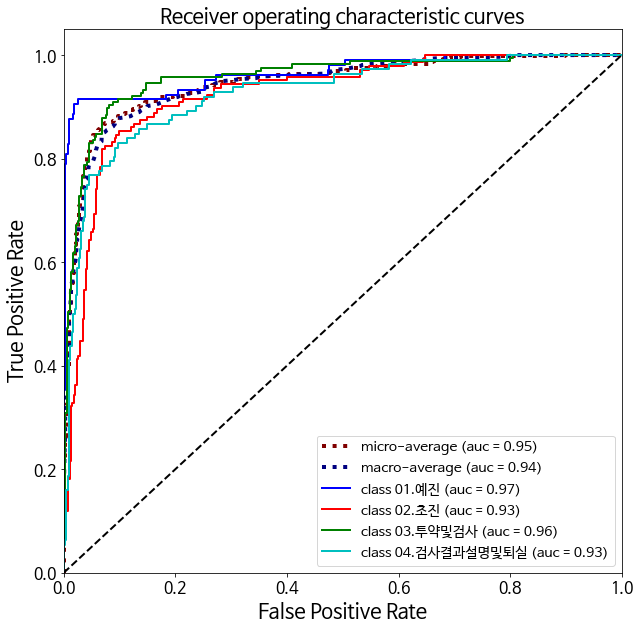

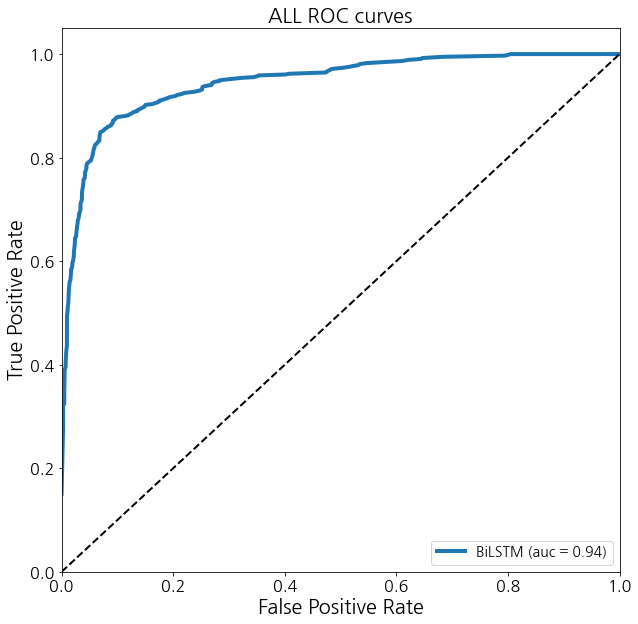

In [26]:
####################################
# ROC curves
####################################

nameList = [model_type]
all_fpr = dict()
all_tpr = dict()
each_aucs = dict()
# for model, clf_name in zip([model_lr], nameList):
for model, clf_name in zip([model], nameList):

    # proba, probList, resultList = utils.ml_predict(model, X_train, Y_train, X_test, Y_test, F_test, clf_name, class_dict, path_result, date='0113')
    utils.ml_predict(predicted_test_tfidf, accuracy_test_tfidf, Y_test, F_test, clf_name, class_dict, path_result, date='0113')
    mic_fpr, mic_tpr, mic_roc_auc, mac_fpr, mac_tpr, mac_roc_auc= utils.drawing_ROCcurve(Y_test, predicted_test_tfidf, savepath= path_result, clf_name = clf_name, name_dict = class_dict)
    all_fpr[f"{clf_name}_fpr"] = mac_fpr
    all_tpr[f"{clf_name}_tpr"] = mac_tpr
    each_aucs[f"{clf_name}_auc"] = mac_roc_auc


# Saving ROC curves: macro average
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.rc('font', family='NanumGothic')
for clf_name in nameList:
    each_auc = each_aucs[f'{clf_name}_auc']
    plt.plot(
        all_fpr[f"{clf_name}_fpr"],
        all_tpr[f"{clf_name}_tpr"],
        label=f"{clf_name} (auc = {each_auc:0.2f})",
        linestyle="-",
        linewidth=4,
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.rc('font', family='NanumGothic')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("False Positive Rate", fontsize=20)
plt.ylabel("True Positive Rate", fontsize=20)
plt.title("ALL ROC curves", fontsize=20)
plt.legend(loc="lower right", fontsize=14)
plt.savefig(f'{path_result}/avg_ROC_{model_type}.png')    


print('Done!')    

## Saving meta graph
import tensorflow.compat.v1 as tf1
tf1.disable_v2_behavior()
tf1.compat.v1.train.export_meta_graph(filename=os.path.join(path_saveDF,'checkpoint','metagraph.meta'),
                                    collection_list=["input_tensor", "output_tensor"])

print('All process done!')
s = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print(s)